Modelacion de Sistemas Multiagentes
* Diego Rosas A01634154
* Alejandro Pizarro A01633784
* Jueves 18 de Agosto de 2022


In [8]:
#%pip install agentpy seaborn 

In [9]:
# Model design
import agentpy as ap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

In [10]:
class ForestModel(ap.Model):

    def setup(self):

        # Create agents (trees)
        n_trees = int(self.p['Dirty cell density'] * (self.p.size**2))
        trees = self.agents = ap.AgentList(self, n_trees)

        # Create grid (forest)
        self.forest = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.forest.add_agents(trees, random=True, empty=True)

        # Initiate a dynamic variable for all trees
        # Condition 0: Alive, 1: Burning, 2: Burned
        self.agents.condition = 0

        # Start a fire from the left side of the grid
        unfortunate_trees = self.forest.agents[0:2, 0:2]
        unfortunate_trees.condition = 1

    def step(self):

        # Select burning trees
        burning_trees = self.agents.select(self.agents.condition == 1)

        # Spread fire
        for tree in burning_trees:
            for neighbor in self.forest.neighbors(tree):
                if neighbor.condition == 0:
                    neighbor.condition = 1 # Neighbor starts burning
            tree.condition = 2 # Tree burns out

        # Stop simulation if no fire is left
        if len(burning_trees) == 0:
            self.stop()

    def end(self):

        # Document a measure at the end of the simulation
        burned_trees = len(self.agents.select(self.agents.condition == 2))
        self.report('Percentage of cleaned cells',
                    burned_trees / len(self.agents))

In [11]:
# Define parameters

parameters = {
    'Dirty cell density': 0.6, # Percentage of grid covered by trees
    'size': 50, # Height and length of the grid
    'steps': 100,
}

In [12]:
# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.forest.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#d62c2c', 2:'#e5e5e5', None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of cell cleaning\n"
                 f"Time-step: {model.t}, Dirty cells: "
                 f"{len(model.agents.select(model.agents.condition == 0))}")

fig, ax = plt.subplots()
model = ForestModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))

In [13]:
# Prepare parameter sample
parameters = {
    'Dirty cell density': ap.Range(0.2, 0.6),
    'size': 100
}
sample = ap.Sample(parameters, n=30)

In [14]:
# Perform experiment
exp = ap.Experiment(ForestModel, sample, iterations=40)
results = exp.run()

Scheduled runs: 1200
Completed: 1200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:06:12.984437


In [15]:
# Save and load data
results.save()
results = ap.DataDict.load('ForestModel')

Data saved to ap_output/ForestModel_2
Loading from directory ap_output/ForestModel_2/
Loading info.json - Successful
Loading parameters_constants.json - Successful
Loading parameters_log.json - Successful
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful


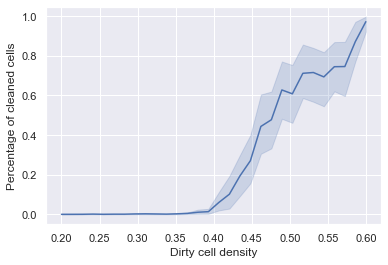

In [18]:
# Plot sensitivity
sns.set_theme()
sns.lineplot(
    data=results.arrange_reporters(),
    x='Dirty cell density',
    y='Percentage of cleaned cells'
);